In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, sim2tra=False)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 3612
Number of labels found: 3612
Number of unique characters: 1873
Characters present: {'𠬠': 454, '㐌': 388, '浪': 356, '朱': 293, '\U000f047c': 261, '尼': 257, '娘': 254, '𢚸': 248, '㝵': 240, '𦋦': 234, '吏': 230, '拱': 223, '之': 198, '埃': 196, '情': 189, '買': 180, '群': 176, '𠳒': 176, '芇': 173, '麻': 172, '固': 167, '𠇮': 162, '𠓨': 160, '欺': 156, '別': 152, '仙': 151, '花': 146, '爫': 144, '昆': 140, '𡗶': 135, '𠄩': 131, '塘': 130, '時': 129, '冲': 126, '畧': 125, '𦖑': 125, '渚': 125, '如': 125, '𠫾': 122, '旦': 122, '渃': 121, '牢': 116, '払': 114, '呐': 113, '強': 112, '分': 112, '些': 111, '低': 108, '傷': 106, '庄': 106, '咍': 105, '生': 103, '鐄': 103, '𢬣': 102, '\U000f061a': 102, '𧗱': 100, '身': 99, '皮': 99, '浽': 99, '仍': 99, '調': 98, '茹': 96, '饒': 92, '庒': 91, '\U000f0832': 91, '沛': 88, '𣈜': 88, '公': 87, '細': 86, '月': 85, '油': 83, '爲': 83, '戈': 83, '排': 82, '扵': 77, '碎': 77, '㗂': 77, '\U000f02c7': 76, '催': 76, '包': 75, '体': 75, '緣': 72, '女': 70, '𬂙': 70, '𡦂': 69, '它': 69, '意': 69, '耒': 69, '迻'

## Visualize the data

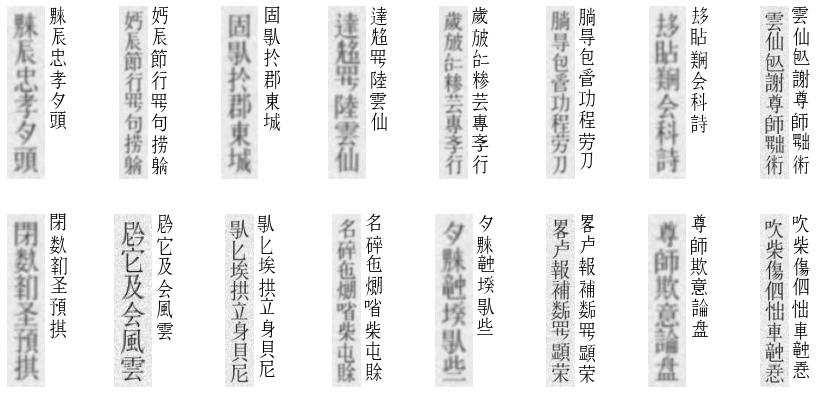

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Bidirectional, GRU,
    Lambda, RepeatVector, Permute, multiply
)
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_weights')(a)
    
    # Calculate the average of all timesteps and multiply by 100 to convert
    # the fraction obtained from the softmax calculation into a percentage
    a = Lambda(
        lambda x: tf.keras.backend.mean(x, axis=1) * 100, 
        name = 'average_weight'
    )(a)
    
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='attention_vector')(a) 
    return multiply([feature_maps, a], name='context_vector') 

In [10]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN and apply attention mechanism
    x = reshape_for_cnn(x, dim_to_keep=-1)
    x = visual_attention(x)
    
    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [11]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [12]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

                                                                    'rnn_output[0][0]',             
                                                                    'label_length[0][0]']           
                                                                                                    
Total params: 15,356,549
Trainable params: 15,352,069
Non-trainable params: 4,480
____________________________________________________________________________________________________


# Training

In [13]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [14]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [15]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [17]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [18]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [19]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

Start training for Fold 01:
Epoch 1/100
204/204 [==============================] - 16s 47ms/step - loss: 50.4052 - val_loss: 53.7390 - lr: 2.0000e-04
Epoch 2/100
204/204 [==============================] - 7s 33ms/step - loss: 44.0007 - val_loss: 44.8179 - lr: 2.0000e-04
Epoch 3/100
204/204 [==============================] - 7s 32ms/step - loss: 29.4952 - val_loss: 27.4714 - lr: 2.0000e-04
Epoch 4/100
204/204 [==============================] - 7s 32ms/step - loss: 15.8943 - val_loss: 14.7499 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 7s 32ms/step - loss: 8.8385 - val_loss: 11.2046 - lr: 2.0000e-04
Epoch 6/100
204/204 [==============================] - 7s 32ms/step - loss: 5.0385 - val_loss: 6.7467 - lr: 2.0000e-04
Epoch 7/100
204/204 [==============================] - 7s 32ms/step - loss: 2.8784 - val_loss: 5.2100 - lr: 2.0000e-04
Epoch 8/100
204/204 [==============================] - 7s 33ms/step - loss: 1.6638 - val_loss: 4.5555 - lr: 2.0000e-04
Epoch 9/10

204/204 [==============================] - 7s 33ms/step - loss: 0.0163 - val_loss: 2.1373 - lr: 1.2500e-05
Epoch 38/100
202/204 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 38: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.3913044
204/204 [==============================] - 7s 32ms/step - loss: 0.0160 - val_loss: 2.1387 - lr: 1.2500e-05
Epoch 39/100
203/204 [============================>.] - ETA: 0s - loss: 0.0158 - Mean edit distance: 1.4076087
Restored weights from the end of epoch: 34
204/204 [==============================] - 7s 33ms/step - loss: 0.0158 - val_loss: 2.1424 - lr: 6.2500e-06
Epoch 39: early stopping
Finish training for Fold 01

Start training for Fold 02:
Epoch 1/100
204/204 [==============================] - 13s 43ms/step - loss: 50.6338 - val_loss: 52.4530 - lr: 2.0000e-04
Epoch 2/100
204/204 [==============================] - 7s 32ms/step - loss: 44.3020 - val_loss: 44.8794 - lr: 2.0000e-04
Epoch 3/100


Epoch 35/100
202/204 [============================>.] - ETA: 0s - loss: 0.0131
Epoch 35: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.5010871
204/204 [==============================] - 7s 33ms/step - loss: 0.0131 - val_loss: 2.1403 - lr: 1.0000e-04
Epoch 36/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0125 - val_loss: 2.1416 - lr: 5.0000e-05
Epoch 37/100
202/204 [============================>.] - ETA: 0s - loss: 0.0120
Epoch 37: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.5201088
204/204 [==============================] - 7s 33ms/step - loss: 0.0120 - val_loss: 2.1243 - lr: 5.0000e-05
Epoch 38/100
203/204 [============================>.] - ETA: 0s - loss: 0.0117 - Mean edit distance: 1.5336957
Restored weights from the end of epoch: 33
204/204 [==============================] - 7s 33ms/step - loss: 0.0117 - val_loss: 2.1285 - lr: 2.5000e-05
Epoch 38: early stopping
Fi

Epoch 33/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0139 - val_loss: 2.2954 - lr: 5.0000e-05
Epoch 34/100
203/204 [============================>.] - ETA: 0s - loss: 0.0134
Epoch 34: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.4269323
204/204 [==============================] - 7s 33ms/step - loss: 0.0134 - val_loss: 2.2998 - lr: 5.0000e-05
Epoch 35/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0131 - val_loss: 2.2766 - lr: 2.5000e-05
Epoch 36/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0128 - val_loss: 2.2760 - lr: 2.5000e-05
Epoch 37/100
202/204 [============================>.] - ETA: 0s - loss: 0.0126
Epoch 37: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.4269323
204/204 [==============================] - 7s 33ms/step - loss: 0.0126 - val_loss: 2.2814 - lr: 2.5000e-05
Epoch 38/100
204/204 [==========================

204/204 [==============================] - 7s 34ms/step - loss: 0.0204 - val_loss: 2.0467 - lr: 1.0000e-04
Epoch 28/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0191 - val_loss: 2.0298 - lr: 1.0000e-04
Epoch 29/100
204/204 [==============================] - 7s 34ms/step - loss: 0.0181 - val_loss: 2.0182 - lr: 1.0000e-04
Epoch 30/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0170 - val_loss: 2.0186 - lr: 1.0000e-04
Epoch 31/100
202/204 [============================>.] - ETA: 0s - loss: 0.0161
Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.4858092
204/204 [==============================] - 7s 33ms/step - loss: 0.0161 - val_loss: 2.0233 - lr: 1.0000e-04
Epoch 32/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0155 - val_loss: 1.9954 - lr: 5.0000e-05
Epoch 33/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0148 - val_loss: 2.0072 - lr: 5.0000e-

Epoch 7/100
204/204 [==============================] - 7s 33ms/step - loss: 2.8652 - val_loss: 6.0955 - lr: 2.0000e-04
Epoch 8/100
204/204 [==============================] - 7s 33ms/step - loss: 1.6173 - val_loss: 5.0965 - lr: 2.0000e-04
Epoch 9/100
204/204 [==============================] - 7s 33ms/step - loss: 0.9497 - val_loss: 3.8197 - lr: 2.0000e-04
Epoch 10/100
204/204 [==============================] - 7s 33ms/step - loss: 0.5799 - val_loss: 3.2387 - lr: 2.0000e-04
Epoch 11/100
204/204 [==============================] - 7s 33ms/step - loss: 0.3730 - val_loss: 3.0372 - lr: 2.0000e-04
Epoch 12/100
204/204 [==============================] - 7s 33ms/step - loss: 0.2528 - val_loss: 2.7986 - lr: 2.0000e-04
Epoch 13/100
204/204 [==============================] - 7s 33ms/step - loss: 0.1862 - val_loss: 2.7847 - lr: 2.0000e-04
Epoch 14/100
204/204 [==============================] - 7s 34ms/step - loss: 0.1427 - val_loss: 2.5638 - lr: 2.0000e-04
Epoch 15/100
204/204 [=====================

Epoch 3/100
204/204 [==============================] - 7s 33ms/step - loss: 27.2064 - val_loss: 23.2925 - lr: 2.0000e-04
Epoch 4/100
204/204 [==============================] - 7s 33ms/step - loss: 15.1908 - val_loss: 13.4804 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 7s 33ms/step - loss: 8.7362 - val_loss: 9.4744 - lr: 2.0000e-04
Epoch 6/100
204/204 [==============================] - 7s 33ms/step - loss: 5.0876 - val_loss: 6.5503 - lr: 2.0000e-04
Epoch 7/100
204/204 [==============================] - 7s 33ms/step - loss: 2.9147 - val_loss: 5.0903 - lr: 2.0000e-04
Epoch 8/100
204/204 [==============================] - 7s 33ms/step - loss: 1.6822 - val_loss: 4.4945 - lr: 2.0000e-04
Epoch 9/100
204/204 [==============================] - 7s 33ms/step - loss: 1.0000 - val_loss: 3.6917 - lr: 2.0000e-04
Epoch 10/100
204/204 [==============================] - 7s 33ms/step - loss: 0.6137 - val_loss: 3.6721 - lr: 2.0000e-04
Epoch 11/100
204/204 [=====================

Epoch 1/100
204/204 [==============================] - 13s 43ms/step - loss: 50.3823 - val_loss: 52.9466 - lr: 2.0000e-04
Epoch 2/100
204/204 [==============================] - 7s 33ms/step - loss: 44.1814 - val_loss: 44.0743 - lr: 2.0000e-04
Epoch 3/100
204/204 [==============================] - 7s 33ms/step - loss: 31.2732 - val_loss: 26.3131 - lr: 2.0000e-04
Epoch 4/100
204/204 [==============================] - 7s 33ms/step - loss: 16.1611 - val_loss: 13.8783 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 7s 33ms/step - loss: 8.5218 - val_loss: 9.2933 - lr: 2.0000e-04
Epoch 6/100
204/204 [==============================] - 7s 33ms/step - loss: 4.6866 - val_loss: 7.0996 - lr: 2.0000e-04
Epoch 7/100
204/204 [==============================] - 7s 33ms/step - loss: 2.5845 - val_loss: 5.4849 - lr: 2.0000e-04
Epoch 8/100
204/204 [==============================] - 7s 34ms/step - loss: 1.4509 - val_loss: 4.0953 - lr: 2.0000e-04
Epoch 9/100
204/204 [==================

Epoch 38/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0124 - val_loss: 2.0124 - lr: 2.5000e-05
Epoch 39/100
203/204 [============================>.] - ETA: 0s - loss: 0.0122
Epoch 39: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.4199879
204/204 [==============================] - 7s 33ms/step - loss: 0.0122 - val_loss: 2.0110 - lr: 2.5000e-05
Epoch 40/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0120 - val_loss: 1.9879 - lr: 1.2500e-05
Epoch 41/100
204/204 [==============================] - 7s 34ms/step - loss: 0.0118 - val_loss: 1.9951 - lr: 1.2500e-05
Epoch 42/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0117 - val_loss: 1.9838 - lr: 1.2500e-05
Epoch 43/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0114 - val_loss: 1.9905 - lr: 1.2500e-05
Epoch 44/100
203/204 [============================>.] - ETA: 0s - loss: 0.0113
Epoch 44: ReduceLROnPlate

Epoch 24/100
203/204 [============================>.] - ETA: 0s - loss: 0.0265
Epoch 24: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.5217391
204/204 [==============================] - 7s 32ms/step - loss: 0.0265 - val_loss: 2.5682 - lr: 2.0000e-04
Epoch 25/100
204/204 [==============================] - 7s 34ms/step - loss: 0.0245 - val_loss: 2.5033 - lr: 1.0000e-04
Epoch 26/100
203/204 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.5027174
204/204 [==============================] - 7s 34ms/step - loss: 0.0228 - val_loss: 2.4981 - lr: 1.0000e-04
Epoch 27/100
204/204 [==============================] - 7s 34ms/step - loss: 0.0217 - val_loss: 2.4668 - lr: 5.0000e-05
Epoch 28/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0210 - val_loss: 2.4893 - lr: 5.0000e-05
Epoch 29/100
204/204 [==========================

Epoch 14/100
204/204 [==============================] - 7s 33ms/step - loss: 0.1310 - val_loss: 2.2838 - lr: 2.0000e-04
Epoch 15/100
204/204 [==============================] - 7s 33ms/step - loss: 0.1043 - val_loss: 2.2066 - lr: 2.0000e-04
Epoch 16/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0859 - val_loss: 2.0625 - lr: 2.0000e-04
Epoch 17/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0720 - val_loss: 2.0925 - lr: 2.0000e-04
Epoch 18/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0612 - val_loss: 2.0508 - lr: 2.0000e-04
Epoch 19/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0531 - val_loss: 1.9909 - lr: 2.0000e-04
Epoch 20/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0454 - val_loss: 1.9365 - lr: 2.0000e-04
Epoch 21/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0398 - val_loss: 1.9424 - lr: 2.0000e-04
Epoch 22/100
204/204 [==================

Epoch 4/100
204/204 [==============================] - 7s 33ms/step - loss: 14.7581 - val_loss: 13.0456 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 7s 33ms/step - loss: 7.9632 - val_loss: 8.8227 - lr: 2.0000e-04
Epoch 6/100
204/204 [==============================] - 7s 33ms/step - loss: 4.3791 - val_loss: 6.6698 - lr: 2.0000e-04
Epoch 7/100
204/204 [==============================] - 7s 33ms/step - loss: 2.4269 - val_loss: 5.4556 - lr: 2.0000e-04
Epoch 8/100
204/204 [==============================] - 7s 33ms/step - loss: 1.3375 - val_loss: 3.9848 - lr: 2.0000e-04
Epoch 9/100
204/204 [==============================] - 7s 33ms/step - loss: 0.7648 - val_loss: 3.4739 - lr: 2.0000e-04
Epoch 10/100
204/204 [==============================] - 7s 33ms/step - loss: 0.4658 - val_loss: 3.2057 - lr: 2.0000e-04
Epoch 11/100
204/204 [==============================] - 7s 33ms/step - loss: 0.3012 - val_loss: 2.9125 - lr: 2.0000e-04
Epoch 12/100
204/204 [======================

Epoch 40/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0221 - val_loss: 2.2211 - lr: 6.2500e-06
Epoch 41/100
203/204 [============================>.] - ETA: 0s - loss: 0.0217
Epoch 41: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
 - Mean edit distance: 1.4344808
204/204 [==============================] - 7s 33ms/step - loss: 0.0217 - val_loss: 2.2190 - lr: 6.2500e-06
Epoch 42/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0215 - val_loss: 2.2261 - lr: 3.1250e-06
Epoch 43/100
203/204 [============================>.] - ETA: 0s - loss: 0.0211
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
 - Mean edit distance: 1.4290459
204/204 [==============================] - 7s 33ms/step - loss: 0.0212 - val_loss: 2.2201 - lr: 3.1250e-06
Epoch 44/100
203/204 [============================>.] - ETA: 0s - loss: 0.0211 - Mean edit distance: 1.4371982
Restored weights from the end of epoch: 39
204/204 [=======

## Get the best CRNN model and its results

In [20]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.39402174949646
23/23 [==============================] - 0s 14ms/step - loss: 2.1332
Fold 02 - Mean edit distance: 1.517391324043274
23/23 [==============================] - 0s 14ms/step - loss: 2.1216
Fold 03 - Mean edit distance: 1.4269323348999023
23/23 [==============================] - 0s 14ms/step - loss: 2.2760
Fold 04 - Mean edit distance: 1.4695048332214355
23/23 [==============================] - 0s 14ms/step - loss: 1.9302
Fold 05 - Mean edit distance: 1.5446860790252686
23/23 [==============================] - 0s 14ms/step - loss: 2.2454
Fold 06 - Mean edit distance: 1.4885265827178955
23/23 [==============================] - 0s 14ms/step - loss: 1.8653
Fold 07 - Mean edit distance: 1.422101378440857
23/23 [==============================] - 0s 14ms/step - loss: 1.9720
Fold 08 - Mean edit distance: 1.4891303777694702
23/23 [==============================] - 0s 14ms/step - loss: 2.4333
Fold 09 - Mean edit distance: 1.3647342920303345
23/23 [====

Fold 8 has the best loss: 1.6798887252807617


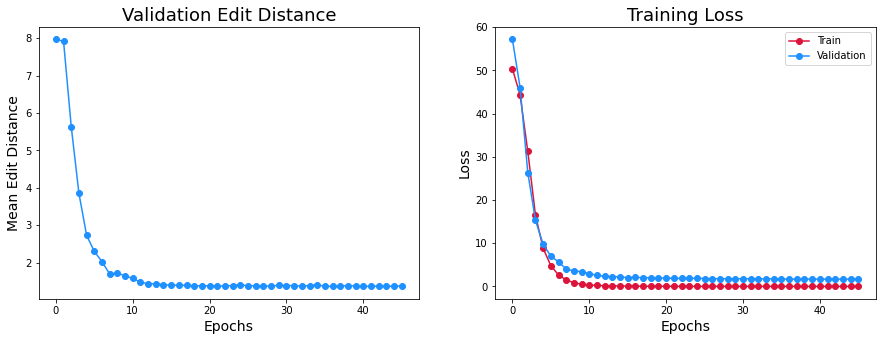

In [21]:
print('Fold', best_fold_idx, 'has the best loss:', best_loss)
plot_training_results(best_history, best_edist_log, 'CRNNxNonPreHS.png')
best_model.save('CRNNxNonPreHS.h5')

# Inference

In [22]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [23]:
reloaded_model = load_model('CRNNxNonPreHS.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_9"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

                                                                    'label_length[0][0]',           
                                                                    'rnn_output[0][0]']             
                                                                                                    
Total params: 15,356,549
Trainable params: 15,352,069
Non-trainable params: 4,480
____________________________________________________________________________________________________


## On test dataset

Batch 1: ['𡛔辰節行\U000f047c句捞𨉓', '達𠸜\U000f047c陸雲仙', '\U000f094e𤳆𥪝𡎝𠊛些', '尊師欺意論盘', '柴朱𠀧道符神\U000f0761蹺', '𠬠\U000f047c貝\U000f045a𭛣茄', '雖浪㵢泣尼匕', '呂\U000f047c柴沛𣴓唎爫之', '調\U000f0761饒𧼋𠓨棱𨑗𡽫', '咍\U000f047c𠬠屡山\U000f025f蹺些', '雲仙浽陣雷霆', '戈䀡\U000f061a倍踈兮㐌仃', '冲車質合苦無', '圭茄扵郡西川', '別𡆫催固上程爫之', '河溪戈妬拱𧵆']

Batch 2: ['呂\U000f047c些沛蹺\U000f0803爫之', '䜹浪便妾𠫾塘', '𦖻𦖑𢈱呐𢬣連𢭂簪', '云仙𥄭吏𢚸唹', '前恩思报念徘徊', '詩耒尼妾吀𤼸', '㐌毛麻吏添咍', '汝句愈出愈奇', '埃咍才𡛔劍夷才𤳆', '月娥踈𭛣前程', '𣈗芇香焒功恩朱払', '嘆浪𠦳淡山川', '曰书𠬠幅吲\U000f0803云仙', '云仙暫住𠬠囬𢭂书', '吒浪差几戈𨑮', '陸王𠄩户都芸𠬠欺']

Batch 3: ['朱咍奇吏﨤奇', '𬂙澄京地㐌候細尼', '𠬠𠊛扵府潘章', '𠄩𠊛吏﨤𠄩𠊛', '𦊚𠊛𡎢吏𠬠𣳔爫詩', '舘浪唭几不才𠁀𠸗', '傷柴顔子\U000f01fe揚', '傷柴童子高賒', '陳平㐌𠇍卢欧', '固\U000f0832\U000f084e湿麻淡𨖲高', '欺棋欺𨢇欺琴欺詩', '科尼仙乙𢧚功', '云仙𣃣𨀈蹎𦋦', '伴皮埃乃巴潙', '𠻨𠽐𠊛扵呂廊𠊛𠫾', '塘𠫾𠬠𣎃庒𧵆']



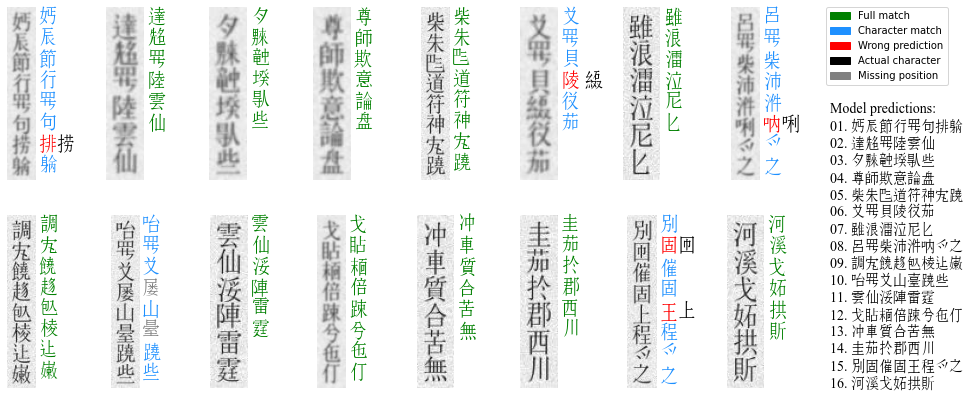

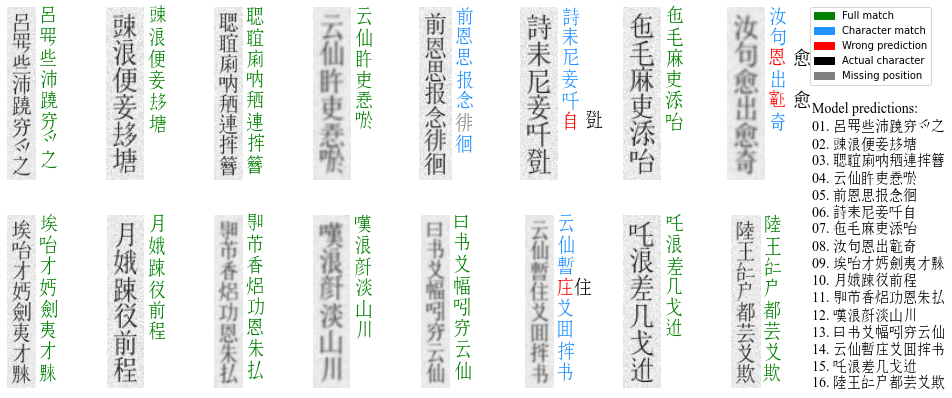

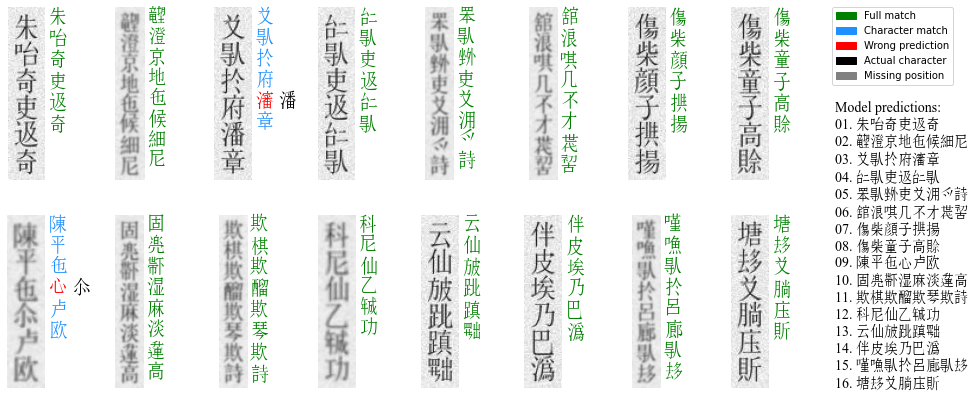

In [24]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [25]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記全書


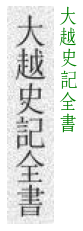

In [26]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))